# Exercício de Programação 3: Compressão de imagens e "Eigenfaces"

<font color="red">**Prazo de submissão: 23:55 do dia 08/02/2021** </font>

2020.2 Álgebra Linear Computacional - DCC - UFMG

Erickson e Fabricio

Instruções:
* Antes de submeter suas soluções, certifique-se de que tudo roda como esperado. Primeiro, **reinicie o kernel** no menu, selecione Kernel$\rightarrow$Restart e então execute **todas as células** (no menu, Cell$\rightarrow$Run All)
* Apenas o arquivo .ipynb deve ser submetido. Ele não deve ser compactado.
* Não deixe de preencher seu nome e número de matrícula na célula a seguir

**Nome do aluno:** Daniel Oliveira Nascimento

**Matricula:** 2020054293

## Introdução

Esse EP será dividido em 2 partes:

1. Compressão de uma imagem. Essa parte é bem próxima do que foi visto na aula "Eckart-Young e aproximações de posto baixo"
1. Encontrar as Eigenfaces de um dataset de rostos.

Para ambas as partes, iremos usar a decomposição em valores singulares (SVD).

Na primeira parte consiramos que a imagem inteira é constituída de valores que possuem alguma relação entre si, mais especificamente, **colunas e linhas** que possuem relação entre si. Isso porque uma imagem pode ser vista como uma matriz, em que cada elemento dessa matriz contém a intensidade do pixel naquela posição. Caso a imagem seja colorida, então cada posição possui na verdade 3 valores, que é o código RGB da cor daquele pixel, porém, para simplificar essa atividade, vamos considerar uma imagem em escala de cinza (preto-e-branco). Nesse caso, o valor de cada elemento na matriz representa a intensidade de cinza daquele pixel, em que 255 é branco e 0 é preto.

Na segunda parte, vamos considerar que os dados são um dataset com **várias** imagens de rostos do dataset [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/). Nesse caso, a nossa matriz é formada por $m$ linhas e $n$ colunas, em que cada linha possui uma imagem de uma face, e cada elemento dessa linha representa o valor de um pixel da imagem. Portanto, uma coluna dessa matriz representa o valor de cinza de todas as imagens em uma mesma posição (mesmo pixel). Como rostos possuem características locais que estão presentes nas imagens de rostos em geral (todo o cabelo é da mesma cor, todo o rosto tem o tom de pele similar...) então o objetivo de usar o SVD é encontrar essas características entre os pixels semânticamente relacionados.

## Parte 0 - Obtendo os dados

Antes de começar, rode os seguintes comandos para baixar os dados necessários para esse exercícios.

In [ ]:
!wget -q --show-progress https://www.dropbox.com/s/xl0cimrnpckslku/img-cachorrinhos.jpeg
!wget -q --show-progress https://www.dropbox.com/s/ds6gdinu12pcls4/dados_img.npy

## Parte 1 - Comprimindo uma imagem

O primeiro passo é carregar a imagem que vamos comprimir:

In [1]:
## NÃO EDITAR ESSA CÉLULA
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## NÃO EDITAR ESSA CÉLULA
A = plt.imread('img-cachorrinhos.jpeg').mean(axis=2)
A.shape

(3888, 5184)

Como podemos ver, a imagem tem uma resolução alta. O nosso objetivo é representar essa imagem sem perder muita informação usando menos bytes do que a quantidade de pixels. Primeiramente, vamos ver como é essa imagem.

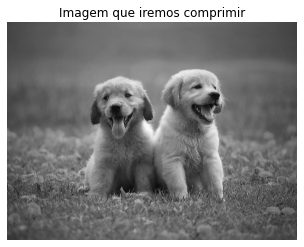

In [3]:
## NÃO EDITAR ESSA CÉLULA
def mostra_img_unica(img, titulo='Imagem'):
    plt.imshow(img, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show();

mostra_img_unica(A, titulo='Imagem que iremos comprimir')

Como descrito acima, uma imagem pode ser vista como uma matriz, em que a posição $i,j$ na matriz representa a intensidade do pixel da imagem naquela posição. Em imagens reais (de pessoas, paisagens, animais, etc.) geralmente existe muita redundância entre os pixels, porque pixels próximos tendem a ter valores próximos. Além disso, em uma determinada região da imagem pode ser que haja pouca variação dos valores dos pixels, principalmente em regiões referentes ao *background* da imagem. Portanto, nessa matriz, ao encontrar colunas ou linhas que podem ser descritas em função de outras, podemos potencialmente encontrar uma forma de comprimir a imagem. Para isso, vamos usar o SVD.

Referência no momento da [aula](https://youtu.be/4H1a6ZMkR98?t=1309).

**1.1** Faça a decomposição SVD da matriz $A$ da imagem acima. Isso pode ser feito usando a função [`np.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html). Essa função faz a operação do SVD $A = U \Sigma V^\top$ e retorna:

- A matriz resultado $U$.
- Os valores singulares $\sigma_i$ em um vetor, ordenado pela sua magnitude em ordem descendente.
- A matriz resultado $V^\top$ (ele já retorna o transposto, não é necessário transpor nada depois da operação).

Guarde os resultados da decomposição SVD nas variáveis **U** (*1.1.1*), **Sigma_vet** (*1.1.2*) e **Vt** (*1.1.3*).

In [4]:
## Insira seu código aqui
U, Sigma_vet, Vt = np.linalg.svd(A)

**1.2** A função `np.linalg.svd` retorna os valores singulares $\sigma_i$ como um vetor. Porém, como em aula estamos usando os valores singulares em uma matriz diagonal $\Sigma$, então vamos transformar esse vetor em uma matriz diagonal. Para isso, podemos usar a função [`np.diag`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html). Salve o resultado em uma variável chamada **Sigma**.


In [5]:
## Insira seu código aqui
Sigma = np.diag(Sigma_vet)
print('dimensões:\nU: {} - Sigma: {} - Vt: {}'.format(U.shape, Sigma.shape, Vt.shape))

dimensões:
U: (3888, 3888) - Sigma: (3888, 3888) - Vt: (5184, 5184)


**1.3** Agora que encontramos os valores e vetores singulares, podemos fazer uma reconstrução da imagem original a partir de **U**, **Sigma** e **Vt**. Para isso basta seguir a equação matricial do SVD: $A = U \Sigma V^\top$. Porém, podemos alterar a quantidade de vetores singulares (e valores singulares) usados para ter uma reconstrução aproximada da imagem. A quantidade de vetores e valores singulares usados é chamada de *posto* da aproximação. 

Como podemos guardar bem menos vetores que o *SVD completo*, isso apresenta uma potencial compressão dos dados. Vamos reconstruir a imagem original fazendo uma aproximação de posto 3. Ou seja, vamos usar apenas os 3 primeiros vetores singulares esquerdos, os 3 primeiros valores singulares, e os 3 primeiros vetores singulares direito. 

Para isso, crie uma função chamada **reconstrucao_aproximada**, que recebe as matrizes $U$, $\Sigma$ e $V^\top$, além do valor $k$ que representa o posto da aproximação. Essa função então deve usar apenas os vetores e valores singulares especificados pelo posto para reconstruir a imagem e retorná-la. Após isso, chame a função para fazer a reconstrução de posto 3 citada acima, e guarde o resultado na variável **imgReconst_3**. Depois disso, se quisermos podemos visualizar a imagem aproximada usando a função *mostra_img_unica*.

Referência em [aula](https://youtu.be/4H1a6ZMkR98?t=1457).

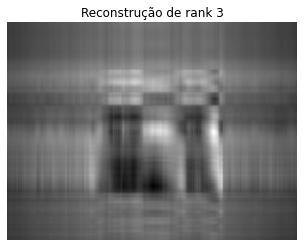

In [6]:
## Insira seu código aqui
def reconstrucao_aproximada(U, Sigma, Vt, k):
    return U[:, :k] @ Sigma[:k, :k] @ Vt[:k, :]
imgReconst_3 = reconstrucao_aproximada(U, Sigma, Vt, k=3)
mostra_img_unica(imgReconst_3, 'Reconstrução de rank 3')

**1.4** Dependendo do posto da aproximação, teremos uma reconstrução de qualidade melhor ou pior. Uma forma de visualizar o quanto os primeiros valores singulares são importantes é "plotar" um gráfico que mostra os valores. Como a magnitude dos valores singulares pode variar muito, se apenas plotarmos os valores diretamente no gráfico pode resultar apenas em um gráfico em formato de "L" que realmente não nos diz muito. Por isso, existem duas práticas comuns:

1. Calcular o $\log$ dos valores singulares e plotá-los.
1. Calcular o *acumulativo* dos valores singulares e plotá-los com relação a soma total.

Para a abordagem 1, podemos usar a função [`np.log`](https://numpy.org/doc/stable/reference/generated/numpy.log.html), e para a abordagem 2 podemos usar as funções [`np.cumsum`](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) para calcular o acumulativo de um vetor, e `np.sum` para calcular a soma total (ou usar o ultimo valor do vetor retornado por `np.cumsum`). Note que para esse exercício devemos usar a variável **Sigma_vet**, já que queremos os resultados em um vetor (e não uma matriz). Salve os resultados nas variáveis **log_Sigma** (*1.4.1*) e **cumul_Sigma** (*1.4.2*). Depois disso visualize os gráficos usando a função *mostra_valores_sinigulares*, que está disponível abaixo.

Referência em [aula](https://youtu.be/4H1a6ZMkR98?t=1809).

In [7]:
## Insira seu código aqui
log_Sigma = np.log(Sigma_vet)
cumul_Sigma = np.cumsum(Sigma_vet) / np.sum(Sigma_vet)

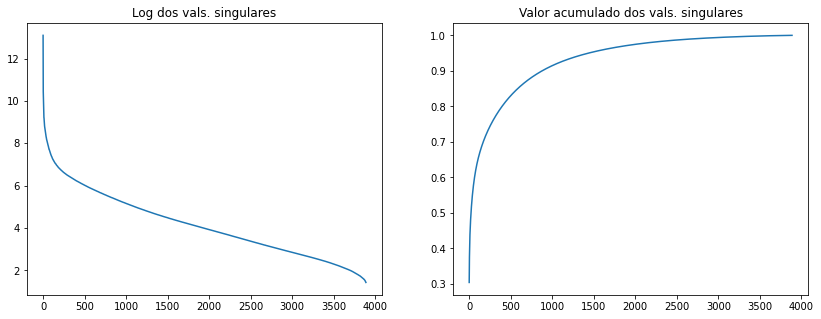

In [8]:
## NÃO EDITAR ESSA CÉLULA
def mostra_valores_singulares(log_Sigma, cumul_Sigma):
    fig, ax = plt.subplots( figsize=(14, 5), nrows=1, ncols=2 )
    ax[0].plot(log_Sigma)
    ax[0].set_title('Log dos vals. singulares')

    ax[1].plot(cumul_Sigma)
    ax[1].set_title('Valor acumulado dos vals. singulares')

mostra_valores_singulares(log_Sigma, cumul_Sigma)

**1.5** Uma forma de medir a qualidade das imagens aproximadas é através da métrica RMSE, que tem como base as diferências *pixel-a-pixel* entre a imagem reconstruída e a imagem original. Crie uma função **calcula_RMSE** que recebe a imagem original e a imagem aproximada, e calcule o RMSE entre as duas. Para isso, podemos usar a função [`np.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html). Depois use essa função para calcular o RMSE para a aproximação que criamos acima **imgReconst_3**, e a imagem original **A**. Salve o resultado em uma variável chamada **rmseReconst_3**.

Referência em [aula](https://youtu.be/4H1a6ZMkR98?t=1622).

In [9]:
## Insira seu código aqui
def calcula_RMSE(img_original, img_rec):
    return np.linalg.norm(img_original - img_rec)
rmseReconst_3 = calcula_RMSE(imgReconst_3, A)
print(rmseReconst_3)

66622.40268017154


**1.6** Como dito acima, dependendo do posto que usamos para a aproximação a imagem tem uma qualidade melhor ou pior. A aproximação de posto 3 feita acima não possui uma qualidade muito boa, mesmo que seja possível perceber que é a imagem original sendo reconstruída. Vamos então agora fazer aproximações usando postos diferentes para verificar como a qualidade muda com $k$. Para isso faça:

1. Uma aproximação de posto 10, e calcule o RMSE. Salve os resultados nas variáveis **imgReconst_10** (*1.6.1*) e **rmseReconst_10** (1.6.2).
1. Uma aproximação de posto 100, e calcule o RMSE. Salve os resultados nas variáveis **imgReconst_100** (*1.6.3*) e **rmseReconst_100** (1.6.4).
1. Uma aproximação de posto 500, e calcule o RMSE. Salve os resultados nas variáveis **imgReconst_500** (*1.6.5*) e **rmseReconst_500** (1.6.6).

Para fazer cada um dos passos acima, basta fazer o mesmo que foi feito para obter **imgReconst_3** e **rmseReconst_3**, apenas variando-se $k$.

In [10]:
## Insira seu código aqui
imgReconst_10 = reconstrucao_aproximada(U, Sigma, Vt, k=10)
rmseReconst_10 = calcula_RMSE(imgReconst_10, A)

imgReconst_100 = reconstrucao_aproximada(U, Sigma, Vt, k=100)
rmseReconst_100 = calcula_RMSE(imgReconst_100, A)

imgReconst_500 = reconstrucao_aproximada(U, Sigma, Vt, k=500)
rmseReconst_500 = calcula_RMSE(imgReconst_500, A)

Depois de obter cada reconstrução podemos visualizá-las:

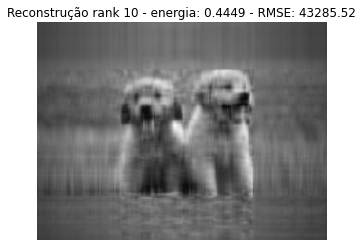

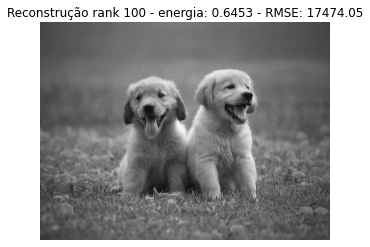

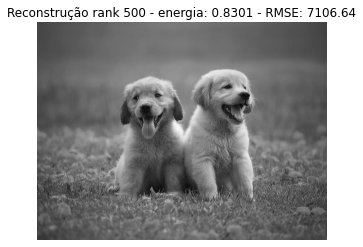

In [11]:
## NÃO EDITAR ESSA CÉLULA
mostra_img_unica( imgReconst_10, 'Reconstrução rank 10 - energia: {:.4f} - RMSE: {:.2f}'.format(cumul_Sigma[10], rmseReconst_10) )
mostra_img_unica( imgReconst_100, 'Reconstrução rank 100 - energia: {:.4f} - RMSE: {:.2f}'.format(cumul_Sigma[100], rmseReconst_100) )
mostra_img_unica( imgReconst_500, 'Reconstrução rank 500 - energia: {:.4f} - RMSE: {:.2f}'.format(cumul_Sigma[500], rmseReconst_500) )

**1.7** Agora vamos calcular o quanto de espaço em memória estamos ocupando ao fazer essas aproximações. Ao comparar esse uso com o uso de memória da imagem original, podemos ter uma idéia de o quanto estamos economizando em espaço na memória. Crie uma função **calcula_qtd_elementos** que recebe os arrays **U**, **Sigma_vet** e **Vt** e retorne a soma da quantidade de elementos desses arrays. Uma funcionalidade que pode ser útil é o atributo `.size` dos `np.arrays`.

Repare que, para calcular essa quantiade para uma aproximação de posto $k$, usamos as matrizes limitadas aos $k$ vetores que são usadas para aquela aproximação, e apenas os $k$ primeiros valores singulares (similar as limitações de linhas e colunas que a função **reconstrucao_aproximada** faz).

Calcule a quantidade de elementos usadas para as aproximações anteriores de posto 10, 100 e 500, e salve os resultados em  **uso_k_10** (*1.7.1*), **uso_k_100** (*1.7.2*), **uso_k_500** (*1.7.3*).

Referência na [aula](https://youtu.be/4H1a6ZMkR98?t=2046).

In [12]:
## Insira seu código aqui
def calcula_qtd_elementos(U, Sigma_vet, Vt, k):
    return U[:, :k].size + Sigma_vet[:k] + Vt[:k, :].size
uso_k_10 = calcula_qtd_elementos(U, Sigma_vet, Vt, k=10)
uso_k_100 = calcula_qtd_elementos(U, Sigma_vet, Vt, k=100)
uso_k_500 = calcula_qtd_elementos(U, Sigma_vet, Vt, k=500)

Mostrando o uso em porcentagem:

In [13]:
## NÃO EDITAR ESSA CÉLULA
uso_total = A.size
print( 'uso para k = 10: {:.2f}% do total'.format(uso_k_10 * 100 / uso_total) )
print( 'uso para k = 100: {:.2f}% do total'.format(uso_k_100 * 100 / uso_total) )
print( 'uso para k = 500: {:.2f}% do total'.format(uso_k_500 * 100 / uso_total) )

TypeError: unsupported format string passed to numpy.ndarray.__format__

**1.8** Mesmo com os gráficos dos valores singulares vistos na questão **1.4**, a escolha de $k$ pode ser um pouco arbitrária. Por isso, vamos adotar o critério de escolher o menor $k$ que preserve 80% da *energia*. Crie uma função chamada **get_limite** que receba a quantidade de energia mínima desejada, além do vetor **cumul_Sigma** com o acumulado dos valores singulares, e retorne o menor $k$ que preserve essa energia.

Depois disso, chame a função usando `energia=0.8` para calcular qual o valor de $k$ que atende a esse valor. Salve o resultado na variável **lim_energ**.

Referência em [aula](https://youtu.be/4H1a6ZMkR98?t=1918).

In [15]:
## Insira seu código aqui
def get_limite(energia, cumul_Sigma):
    k = 0
    while cumul_Sigma[k] < energia: k += 1
    return k
lim_energia = get_limite(energia=0.8, cumul_Sigma=cumul_Sigma)
print(lim_energia)

396


## Parte 2 - Eigenfaces

Como vimos na parte 1, uma imagem pode ser vista como uma matriz em que cada posição na matriz representa a intensidade do pixel na posição correspondente. Porém, outra aplicação muito interessante do SVD em processamento de imagens é a de representar um conjunto de dados inteiro (como um conjunto de imagens) através dos vetores e valores singulares. Nessa segunda parte, vamos trabalhar com dados desse tipo, em que cada linha da matriz por si só é uma imagem inteira. As imagens que vamos usar são de rostos de pessoas, de forma com que as faces estão alinhadas (em todas as imagens os olhos, boca, nariz, etc. estão mais ou menos numa mesma região na imagem).

A partir disso, podemos "esticar" as matrizes de todas as imagens em um array 1D, que é um vetor. Ao posicionar cada vetor de todas as imagens verticalmente, voltamos a ter uma matriz, em que cada linha representa um vetor de uma imagem, e cada elemento nessa linha é um pixel da imagem. Vamos ver isso lendo os dados e mostrando uma imagem:

tamanho da matriz: (13233, 4096)
img. de exemplo:


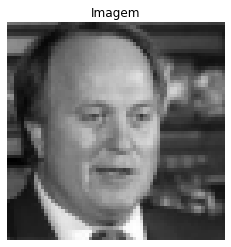

In [16]:
## NÃO EDITAR ESSA CÉLULA

## Função usada para receber o vetor de uma imagem "esticada" e 
## transformá-lo de volta em uma matriz como a imagem real
def vetor_para_img(x):
    if len(x.shape) == 3:
        return x.reshape(-1, 64, 64)
    else:
        return x.reshape(64, 64)

## lendo a matriz
B = np.load('dados_img.npy')
print('tamanho da matriz:', B.shape)

## mostrando uma das imagens a partir do vetor na matriz
print('img. de exemplo:')
mostra_img_unica( vetor_para_img(B[0, :]) )

Como visto acima, essa matriz possui uma dimensionalidade muito maior que a da parte 1. Ela possui 13 mil linhas. Se fizermos a decomposição SVD dessa matriz diretamente e usando o SVD completo, a matriz $U$ teria dimensões muito altas, além de que seria muito custoso.

Vamos calcular a quantidades de bytes necessários para guardar a matriz $U$ caso a decomposição SVD fosse aplicada:

In [17]:
## NÃO EDITAR ESSA CÉLULA
(B.shape[0] ** 2) * 4

700449156

Esse valor pode ser muito custoso para se calcular. Porém, como foi dito na [aula](https://youtu.be/VRvYOxozsas?t=1306) sobre SVD, existe uma relação entre os autovalores e os valores singulares da matriz. Vimos que é possível obter os vetores singulares direitos e os valores singulares de uma matriz $B$ ao aplicar a decomposição espectral na matriz resultante de multiplicar a transposta por ela mesma: $B^\top B$.

Esse fato irá nos ajudar porque, mesmo que a matriz $B$ possua 13 mil linhas, ao computar $B^\top B$, o resultado é uma matriz quadrada que possui dimensões iguais à quantidade de colunas de $B$. Como ela possui bem menos colunas e linhas (4096), então podemos processar essa matriz de forma mais eficiente que a original.

Em especial, podemos fazer a decomposição espectral dessa matriz, e usar as relações citadas acima para obter as matrizes do SVD para fazer aproximações de posto baixo.

**2.1** O primeiro passo para fazer isso é calcular o "vetor linha médio" que essa matriz possui. Para isso, podemos usar a função `.mean()` dos `np.arrays`. Como queremos que a média das linhas seja calculada, então podemos especificar o parâmetro `axis` para evitar que o *numpy* faça a média de toda a matriz. O resultado dessa operação deve ter 4096 elementos. Salve essa média em uma variável **B_media** (*2.1.1*), e depois disso subtraia essa média de cada linha da matriz original **B**, e salve a matriz resultante em uma variável **Bm** (*2.1.2*).

In [18]:
## Insira seu código aqui
B_media = B.mean(axis=0, keepdims=True)
Bm = B - B_media
print(B_media.shape, Bm.shape)

(1, 4096) (13233, 4096)


Essa "linha média" calculada representa os valores médios de todas as linhas da matriz. Como cada linha da matriz é uma imagem de um rosto, então a interpretação semântica dessa média é uma "face média", que representa como seria uma face em geral. Podemos visualizar como é essa "face média":


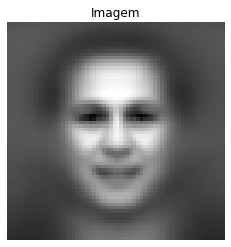

In [19]:
## NÃO EDITAR ESSA CÉLULA
mostra_img_unica( vetor_para_img(B_media.reshape(-1)) )

**2.2** Agora que removemos a média da matriz, podemos obter a matriz quadrada que vamos usar para o processamento. Crie essa matriz a partir da multiplicação de matrizes da transposta de **Bm** com o próprio **Bm**:

$$S = B_m^\top B_m$$

$\color{red}{\textbf{Atenção}}$: é importante que a ordem da multiplicação seja feita como acima: da transposta pré-multiplicando a matriz original. Caso a ordem seja trocada, o `python` irá tentar calcular uma matriz de tamanho 13 mil por 13 mil, o que pode demorar muito tempo e até causar o travamento do programa (e talvez do computador sendo usado), além de não dar o resultado correto.

Salve a matriz resultado em uma variável chamada **S**.

Referência na [aula](https://youtu.be/VRvYOxozsas?t=1306).

In [20]:
## Insira seu código aqui
S = Bm.T @ Bm
print(S.shape)

(4096, 4096)


**2.3** Agora que temos a matriz $S$ quadrada e de dimensões $4096 \times 4096$, podemos calcular a sua decomposição espectral. Isso pode ser feito usando a função [`np.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html), assim como no **EP2**. Salve os autovalores resultantes em uma variável **w2** (*2.3.1*) e os autovetores numa variável **V2** (*2.3.2*).

In [ ]:
## Insira seu código aqui
w2, V2 = np.linalg.eig(S)
print(V2.shape, w2[:10])

Como dito acima, os autovetores de $S$ são os vetores singulares direitos de $B_m$, que é uma matriz que representa características das faces das pessoas. Ao calcular os vetores singulares dessa matriz, o que estamos capturando são características dos dados que a matriz representa. No caso desse exercício, são imagens de faces, e portanto a interpretação que os vetores singulares possuem é de serem as características mais *marcantes* das faces. Como esses vetores estão no mesmo espaço dimensional que as linhas de $B_m$, podemos ainda **vizualizar** em imagens o que esses vetores são. Isso é uma característica muito interessante desse tipo de dados, porque de certa forma estamos visualizando um vetor no espaço $\mathbb{R}^{4096}$:

In [ ]:
## NÃO EDITAR ESSA CÉLULA
fig, ax = plt.subplots( figsize=(14, 16), nrows=5, ncols=5 )
c = 0
for i in range(5):
    for j in range(5):
        eigenface = vetor_para_img( V2[:, c] )
        ax[i, j].imshow(eigenface, cmap='gray')
        ax[i, j].set_title('eigenface nº {}'.format(c))
        ax[i, j].axis('off')
        c += 1

plt.show();

As áreas mais claras nas imagens representam as regiões onde o vetor singular mais corresponde em uma imagem. Podemos ver claramente que cada um representa uma característica diferente das imagens. Essa técnica ficou conhecida como **Eigenfaces**, porque pode ser obtida através de decomposição espectral da matriz (*eigendecomposition*) quando a matriz representa imagens de faces.

**2.4** Agora, para obter os valores singulares de $B_m$ calculamos a raiz dos autovalores de $S$, que estão em **w2**. Para isso, podemos usar a função [`np.sqrt`](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html). Salve os valores singulares numa variável chamada **valores_sing**.

Referência em [aula](https://youtu.be/VRvYOxozsas?t=1879).


In [ ]:
## Insira seu código aqui
valores_sing = np.sqrt(w2)

**2.5** Agora que ja possuímos os valores singulares em um vetor (**valores_sing**), podemos calcular a matriz $\Sigma$ que possui esses valores na sua diagonal. Além disso, também será útil calcular a sua inversa $\Sigma^{-1}$, para mais a frente ser possível de calcular os vetores singulares $U$, que ainda não possuímos (por enquanto temos apenas $V$). Salve o valor de $\Sigma$ em uma variável **Sigma_vals_sing** (2.5.1) e sua inversa em **Sigma_inv** (*2.5.2*). Assim como no exercício **1.2**, a função `np.diag` pode ser útil.

Referência em [aula](https://youtu.be/VRvYOxozsas?t=1974).

In [ ]:
## Insira seu código aqui
Sigma_vals_sing = np.diag(valores_sing)
Sigma_inv = np.diag(1 / valores_sing)
print(Sigma_vals_sing.shape, Sigma_inv.shape)

**2.6** Agora que já possuímos as matrizes $V$ (vetores singulares direitos) e $\Sigma^{-1}$ (inversa dos valores singulares), além da matriz original $B_m$, podemos calcular os vetores singulares esquerdos $U$. Para isso, podemos usar a relação que foi explicada durante a [aula](https://youtu.be/VRvYOxozsas?t=2031):

$$U = B_m V \Sigma^{-1}$$

Porém, não precisamos calcular todos os elementos dessa matriz se quisermos reconstruir apenas algumas imagens. Por exemplo, se quisermos reconstruir apenas as primeiras 10 imagens presentes nos dados, podemos fazer o cálculo acima apenas **com as primeiras 10 linhas de Bm**. Aqui que está o "pulo do gato" que faz ser possível calcular as linhas de $U$ referentes apenas aos usuários que queremos, ao invés de calcular para todas as 13 mil linhas da matriz original.

Calcule a matriz $U$, porém considerando apenas as 10 primeiras linhas de **Bm**, e guarde o valor na variável **U2_10** (*2.6.1*). Depois disso, use esse $U$ resultante para calcular a reconstrução das primeiras 10 imagens usando um posto reduzido $k=200$. Para isso, podemos apenas usar a matriz **U2_10** calculada anteriormente, e as matrizes $\Sigma$ e $V$ que foram também calculadas nos exercícios anteriores, e a função que usamos na parte 1 **reconstrucao_aproximada**. Salve esse resultado na variável **imgs2_10** (*2.6.2*).

Esse exercício é bem parecido com o **1.6**.

In [ ]:
## Insira seu código aqui
U2_10 = Bm[:10] @ V2 @ Sigma_inv

## aproximação de posto baixo
posto_k_q27 = 200
imgs2_10 = reconstrucao_aproximada(U2_10, Sigma_vals_sing, V2.T, k=posto_k_q27)
print(imgs2_10)

Visualizando as reconstruções:

In [ ]:
## NÃO EDITAR ESSA CÉLULA
fig, ax = plt.subplots( figsize=(8, 40), nrows=10, ncols=2 )
for i in range(10):
    img_real = vetor_para_img(B[i])
    img_i = vetor_para_img(B_media + imgs2_10[i])

    ax[i, 0].imshow(img_real, cmap='gray')
    ax[i, 0].set_title('Imagem orig.')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(img_i, cmap='gray')
    ax[i, 1].set_title('Aprox. de posto k={}'.format(posto_k_q27))
    ax[i, 1].axis('off')

plt.show();